In [111]:
import numpy as np
from keras.models import Model, Input, Sequential
from keras.activations import relu
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix
from keras.layers import Activation, BatchNormalization, Conv1D, Dense, MaxPooling1D, Flatten, Dropout

In [102]:
from mat4py import loadmat
TrainNormal = loadmat('D:\\Bihter\\Kanser Sınıflama Makalesi\\Kanser_Entropy-5birim.mat')

In [103]:
TrainNormal.keys()

dict_keys(['DataS', 'DataH'])

In [104]:
TrainS = TrainNormal['DataS']
TrainH = TrainNormal['DataH']

In [105]:
TrainS = np.array(TrainS)
TrainH = np.array(TrainH)
TrainS.shape, TrainH.shape

((1368, 100), (1368, 100))

In [106]:
boyut = TrainS.shape[0]
boyut

1368

In [107]:
X_train2 = np.concatenate((TrainS, TrainH), axis=0)
X = np.expand_dims(X_train2, axis=2)

X.shape, X_train2.shape

((2736, 100, 1), (2736, 100))

In [108]:
from keras.utils import to_categorical

Y = np.zeros(boyut*2)
Y[boyut:] = 1
#Y = to_categorical(Y)
Y.shape

(2736,)

In [112]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=False)
cvscores = []
for train, test in kfold.split(X, Y):
    Y_cat = to_categorical(Y)# Y_categorical burada kullanmamızın sebebi önce yaparsak 
    #StratifiedKFold 1d istiyor ve ozaman hata veriyor. 1d şekilnde sistemi çalıştırmak istiyorsak
    # categorical yapmamdan o zaman Aşağıda Dense(1), softmax yerine sigmoid ve categorical_crossentropy yerine
    #binary_crossentropy yazmamız gerekir.
    #https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
    
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=5, strides=1, input_shape=(100, 1), activation='relu', padding='same'))
    model.add(Conv1D(filters=16, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2 ))
    #model.add((Dropout(0.1)))


    model.add(Conv1D(filters=32, kernel_size=5, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2 ))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2 ))

    #model.add(MaxPooling1D(pool_size=2, strides=2 ))          
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation='relu' ))
    #model.add(Dense(128, activation='relu' ))
    model.add(Dense(64, activation='relu' ))

    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    adam = Adam(lr=0.00001, decay=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    model.fit(X, Y_cat, epochs=10, batch_size=64,verbose=0, 
              validation_split=0.2, shuffle='True')
    scores = model.evaluate(X[test], Y_cat[test], verbose=0)
    
    
    
    #XXXXXXXX Bu arayı ben koydum XXXXXXXXXXXXXX
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    
    # predict probabilities for test set
    yhat_probs = model.predict(X[test], verbose=0)
    # predict crisp classes for test set
    yhat_classes = model.predict_classes(X[test], verbose=0)
    #print("yhat_prob", yhat_probs.shape)
    #print("yhat_class", yhat_classes.shape)
    
    #The predictions are returned in a two-dimensional array, with one row 
    #for each example in the test dataset and one column for the prediction.

    #The scikit-learn metrics API expects a 1D array of actual and 
    #predicted values for comparison, therefore, we must reduce 
    #the 2D prediction arrays to 1D arrays.
    # reduce to 1d array
    yhat_probs = yhat_probs[:, 0]
    #yhat_classes = yhat_classes[:, 0]
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(Y[test], yhat_classes)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(Y[test], yhat_classes)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(Y[test], yhat_classes)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(Y[test], yhat_classes)
    print('F1 score: %f' % f1)
    
    matrix = confusion_matrix(Y[test], yhat_classes)
    print(matrix)
    
    #XXXXXXXX Buraya kadar XXXXXXXXXXXXXX
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    
    
    
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Accuracy: 0.744526
Precision: 0.770161
Recall: 0.697080
F1 score: 0.731801
[[217  57]
 [ 83 191]]
acc: 74.45%
Accuracy: 0.667883
Precision: 0.632184
Recall: 0.802920
F1 score: 0.707395
[[146 128]
 [ 54 220]]
acc: 66.79%
Accuracy: 0.773723
Precision: 0.755102
Recall: 0.810219
F1 score: 0.781690
[[202  72]
 [ 52 222]]
acc: 77.37%
Accuracy: 0.609890
Precision: 0.806122
Recall: 0.289377
F1 score: 0.425876
[[254  19]
 [194  79]]
acc: 60.99%
Accuracy: 0.763736
Precision: 0.703390
Recall: 0.912088
F1 score: 0.794258
[[168 105]
 [ 24 249]]
acc: 76.37%
71.20% (+/- 6.31%)


In [ ]:
acc: 84.49%
acc: 80.84%
acc: 92.34%
acc: 95.24%
acc: 88.46%
88.27% (+/- 5.19%)



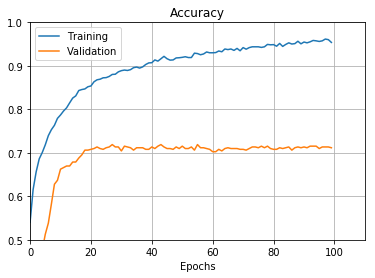

In [29]:
import matplotlib.pyplot as plt 
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.axis([0, 110, .5, 1])
plt.grid(True)
plt.show()

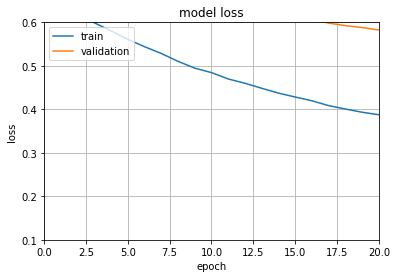

In [30]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, 20, 0.1, .8])
plt.grid(True)
plt.show()

In [ ]:
scores = model.evaluate(X_test, y_test_cat, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))